In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 残差块
 残差块里首先有2个有相同输出通道数的3x3卷积层。 每个卷积层后接一个批量规范化层和ReLU激活函数。
 然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。

In [4]:
class Residual(nn.Module):
    # 若输入通道与输出通道不同，需要使用1x1卷积修改通道数
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides) # 根据传入的strides可能会改变高宽
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1) # 不改变高宽
        if use_1x1conv:
            # 跨层数据通路
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

默认残差块不更改高宽和通道数，若修改了通道数需要使用1x1卷积层

In [14]:
blk = Residual(3,3) 
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在增加输出通道数的同时，减半输出的高和宽

In [15]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型
ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的7x7卷积层后，接步幅为2的的最大池化层。 不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [16]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) 

GoogLeNet在后面接了4个由Inception块组成的模块。 ResNet则使用4个由残差块组成的模块，每个模块使用若干（2）个同样输出通道数的残差块。  由于之前已经使用了步幅为2的最大池化层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [18]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = [] 
    for i in range(num_residuals):
        # 每个模块的第一个残差块使得通道翻倍，高宽减半
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。

In [19]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) # 第二个模块不修改通道以及高宽
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均池化层，以及全连接层输出。

In [20]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

该模型第2-5模块各有4个卷积层（不包括恒等映射的1x1卷积层）。加上第一个卷积层和最后一个全连接层，共有18层。 因此，这种模型通常被称为ResNet-18。

 虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。

In [21]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 使用ResNet-18在Fashion-MNIST数据集上训练

loss 0.010, train acc 0.998, test acc 0.922
976.9 examples/sec on cuda:0


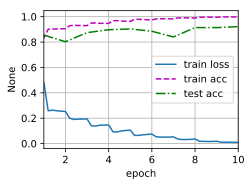

In [22]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())